# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 3: Simulated Annealing** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

In [175]:
import tsplib95
import random
import matplotlib.pyplot as plt
import math
import copy
random.seed(42)

In [184]:
class SimulatedAnnealing():
    def __init__(self, file_name) -> None:
        self.starting_temperature = 5000
        self.current_temperature = self.starting_temperature
        self.temperature_list = []
        self.stopping_temperature = 0.0001
        self.alpha = 0.99
        self.iterations = 1
        self.same_solution_max = 1500
        self.same_cost_diff_max = 150000
        self.route_distance = 0
        self.data = tsplib95.load(file_name)
        self.cities = list(self.data.get_nodes())
        random.shuffle(self.cities) #randomly shuffle the cities
        self.solution = self.cities
        self.best_route_so_far = self.cities
        self.route_distance_list = []
        self.route_cost_list = []

        self.total_temperature_list = []
        self.total_route_cost_list = []

        self.best_route_iteration_list = []
        self.best_route_cost_iteration_list = []

    def initialize(self):
        for i in range(self.iterations):     
            print("Iteration: ", i)
            route, route_cost = self.annealing()
            self.best_route_iteration_list.append(route)
            self.best_route_cost_iteration_list.append(route_cost)

            self.solution = self.cities
            self.best_route_so_far = []
            self.route_distance_list = []
            self.route_cost_list = []
            self.temperature_list = []
            self.current_temperature = self.starting_temperature
            self.route_distance = 0


    def annealing(self):
        """Peforms simulated annealing to find a solution""" 
        same_solution = 0
        same_cost_diff = 0

        while same_solution < self.same_solution_max and same_cost_diff < self.same_cost_diff_max:
            better_solution = self.potential_better_solution(self.solution)
            
            # Check if neighbor is best so far
            cost_diff = self.get_cost(better_solution) - self.get_cost(self.solution)

            # if the new solution is better, accept it
            if cost_diff > 0:
                self.solution = better_solution
                self.best_route_so_far = better_solution
                same_solution = 0
                same_cost_diff = 0
                
            elif cost_diff == 0:
                self.solution = better_solution
                same_solution = 0
                same_cost_diff += 1
            # if the new solution is not better, accept it with a probability of e^(-cost/temp)
            else:
                if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(self.current_temperature)):
                    self.solution = better_solution
                    same_solution = 0
                    same_cost_diff = 0
                else:
                    same_solution +=1
                    same_cost_diff+=1
            # decrement the temperature
            self.current_temperature = self.current_temperature*self.alpha
            self.temperature_list.append(self.current_temperature)
            self.route_cost_list.append(self.get_cost(self.solution))
        self.total_temperature_list.append(self.temperature_list)
        self.total_route_cost_list.append(self.route_cost_list)
        return self.best_route_so_far, self.get_cost(self.best_route_so_far)

    def get_cost(self, state):
        """Calculates cost/fitness for the solution/route."""
        distance = 0
        for i in range(len(state)):
            from_city = state[i]
            to_city = None
            if i+1 < len(state):
                to_city = state[i+1]
            else:
                to_city = state[0]
            distance += self.data.get_weight(from_city, to_city)
        fitness = 1/float(distance)
        return fitness
        
    def potential_better_solution(self, state):
        """Returns neighbor of  your solution."""
        neighbor = copy.deepcopy(state)
        func = random.choice([0,1,2,3])
        if func == 0:
            neighbor = self.inverse(neighbor)
        elif func == 1:
            neighbor = self.insert(neighbor)
        elif func == 2 :
            neighbor = self.swap(neighbor)
        else:
            neighbor = self.swap_routes(neighbor)
        return neighbor 

    def inverse(self, state):
        "Inverses the order of cities in a route between node one and node two"
        node_one = random.choice(state)
        new_list = list(filter(lambda city: city != node_one, state)) #route without the selected node one
        node_two = random.choice(new_list)
        state[min(node_one,node_two):max(node_one,node_two)] = state[min(node_one,node_two):max(node_one,node_two)][::-1]
        return state

    def insert(self, state):
        "Insert city at node j before node i"
        node_j = random.choice(state)
        state.remove(node_j)
        node_i = random.choice(state)
        index = state.index(node_i)
        state.insert(index, node_j)
        
        return state

    def swap(self, state):
        "Swap cities at positions i and j with each other"
        pos_one = random.choice(range(len(state)))
        pos_two = random.choice(range(len(state)))
        state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
        
        return state

    def swap_routes(self, state):
        "Select a subroute from a to b and insert it at another position in the route"
        subroute_a = random.choice(range(len(state)))
        subroute_b = random.choice(range(len(state)))
        subroute = state[min(subroute_a,subroute_b):max(subroute_a, subroute_b)]
        del state[min(subroute_a,subroute_b):max(subroute_a, subroute_b)]
        insert_pos = random.choice(range(len(state)))
        for i in subroute:
            state.insert(insert_pos, i)
        return state
            
    def plot_route(self):
        #Plot Routes
        for i in range(0, len(self.best_route_iteration_list)):
            xs = [self.data.node_coords[i][0] for i in self.best_route_iteration_list[i]]
            ys = [self.data.node_coords[i][1] for i in self.best_route_iteration_list[i]]
            # 'bo-' means blue color, round points, solid lines
            plt.figure()
            plt.plot(xs, ys, label="Distance: " + str(1/self.best_route_cost_iteration_list[i]))
            plt.xlabel('X Coordinates')
            plt.ylabel('Y Coordinates')
            plt.title('Simulated Annealing')
            plt.legend()

    def plot_route_distance_list(self):
        for i in range(0, len(self.total_route_cost_list)):
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('Temperature')
            ax1.set_ylabel('Cost', color=color)
            ax1.plot(self.total_temperature_list[i], self.total_route_cost_list[i], 'r', label="Cost", linewidth=0.5)
            ax1.tick_params(axis='y', labelcolor=color)

Iteration:  0
Iteration:  1


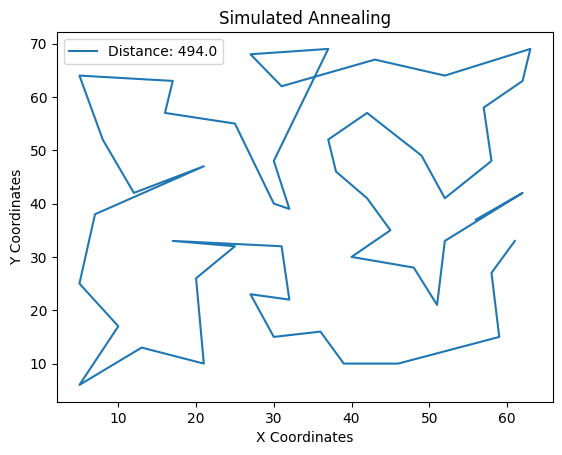

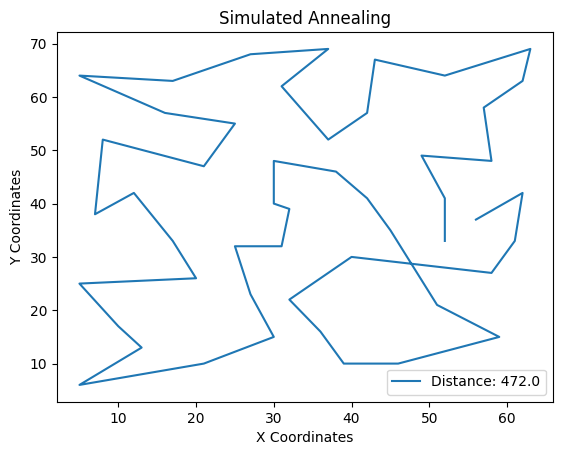

In [185]:
initial = SimulatedAnnealing('eil51.tsp')
initial.same_solution_max = 100
initial.same_cost_diff_max = 500
initial.iterations = 2
initial.initialize()
initial.plot_route()

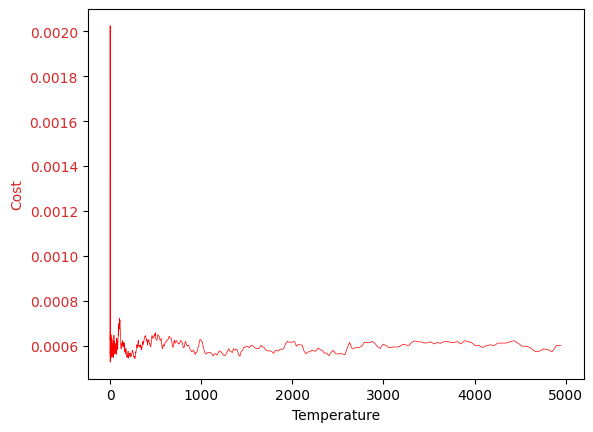

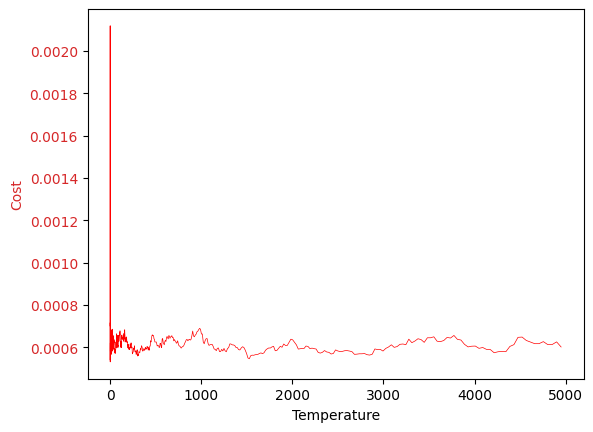

In [186]:
initial.plot_route_distance_list()